# Анализ оттока клиентов "Метанпромбанка"

**Описание проекта:**

Я - аналитик "Метанпромбанка". Задача: проанализировать клиентов регионального банка и выделить сегменты клиентов,
которые склонны уходить из банка.

**Ход исследования:**

- Загрузка и описание данных;
- Предобработка данных:
    - Приведение типов данных;
    - Удаление дубликатов;
    - Обработка пропусков;
- Исследовательский анализ данных:
    - Анализ распределения признаков в разрезе оттока:
        - Проверить зависимость баллов кредитного скоринга и вероятности ухода;
        - Проверить зависимость города проживания и вероятности ухода;
        - Проверить зависимость пола и вероятности ухода;
        - Проверить зависимость возраста и вероятности ухода;
        - Проверить зависимость баллов собственности и вероятности ухода;
        - Проверить зависимость баланса на счете и вероятности ухода;
        - Проверить зависимость количества продуктов, которыми пользуется клиент и вероятности ухода;
        - Проверить влияние наличия кредитной карты на вероятность ухода;
        - На основе давности покупки разделить клиентов на 3 сегмента (неделя, месяц, 6 месяцев) и определить вероятность ухода в каждом сегменте;
        - Проверить зависимость дохода клиента и вероятности ухода;
    - Корреляционный анализ;
- Формулирование и проверка гипотез на основании исследовательского анализа данных;
- Выводы по результатам исследования;
- Сегментация клиентов, у которых отток лучше, чем в среднем по банку (от 500 клиентов на сегмент);
- Приоритезация сегментов;
- Формулировка рекомендаций для бизнеса.

## Загрузим данные и изучите общую информацию

In [1]:
!pip install phik
import phik
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
import math as mth

     |████████████████████████████████| 686 kB 1.2 MB/s eta 0:00:01


In [2]:
try:
    df = pd.read_csv('/datasets/bank_scrooge.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/bank_scrooge.csv')

Объявим функцию, которая будет выводить общую информацию о датафрейме:

In [3]:
def df_info(df):
    print('Общая информация')
    print(df.info(), '\n')
    print('Первые 5 строк')
    display(df.head(5))
    print('Количество явных дубликатов')
    print(df.duplicated().sum(), '\n')
    print('Абсолютное число пропусков')
    print(df.isna().sum(), '\n')

In [4]:
df_info(df)

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB
None 

Первые 5 строк


,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


Количество явных дубликатов
0 

Абсолютное число пропусков
USERID              0
score               0
city                0
gender              0
age                26
equity              0
balance          2295
products            0
credit_card         0
last_activity       0
EST_SALARY          0
churn               0
dtype: int64 



**Из общих данных можно сделать следующие выводы:**
- Необходимо переименовать столбцы;
- Требуется обработка пропусков в столбцах `age` и `balance`;
- Явных дубликатов нет, но на этапе предобработки стоит проверить неявные дубликаты;
- Необходимо изменить типы данных в столбцах `score` и `age` на int.

## Предобработка данных

### Переименование столбцов

In [5]:
df.rename(columns={'USERID': 'user_id', 'EST_SALARY': 'est_salary'}, inplace=True)

### Поиск неявных дубликатов

In [6]:
df.loc[df.duplicated(subset=['user_id'], keep=False)].sort_values(by='user_id').head(10)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1893,116540,883.0,Рыбинск,Ж,55.0,1,362756.49,3,0,1,175920.48,1
7694,116540,887.0,Ярославль,Ж,38.0,0,NaN,1,0,1,119247.61,0
7542,117943,880.0,Ярославль,Ж,40.0,0,NaN,1,1,0,137718.93,0
4866,117943,855.0,Рыбинск,Ж,32.0,6,1036832.93,4,1,1,107792.71,1
5896,120258,905.0,Ярославль,М,30.0,0,NaN,1,1,1,146427.96,0
5863,120258,908.0,Рыбинск,Ж,38.0,4,2213581.63,2,0,1,160327.77,1
1411,123461,829.0,Ярославль,Ж,59.0,0,96222.44,2,0,1,102771.55,1
8638,123461,934.0,Рыбинск,М,34.0,0,NaN,2,1,0,291619.27,0
8164,124450,859.0,Ярославль,Ж,38.0,6,516811.20,1,1,1,95144.63,1
9775,124450,758.0,Рыбинск,Ж,36.0,0,73574.07,2,0,1,79963.59,0


Видно, что одинаковые `user_id` встречаются у пользователей из разных городов, поэтому нельзя назвать эти строки полными дубликатами и их не следует удалять.

### Обработка пропусков

Для столбцов `age` и `balance` создадим признаки, принимающие 1, если в наблюдении пропущено значение признака, и 0, если в наблюдении значение признака не пропущено:

In [7]:
df['pass_age'] = df['age'].isna().astype(int)
df['pass_balance'] = df['balance'].isna().astype(int)

In [8]:
df.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,pass_age,pass_balance
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,0,0
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,0,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,0,1
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,0,0
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,0,0


Построим матрицу корреляций для определения корреляции пропусков с остальными признаками:

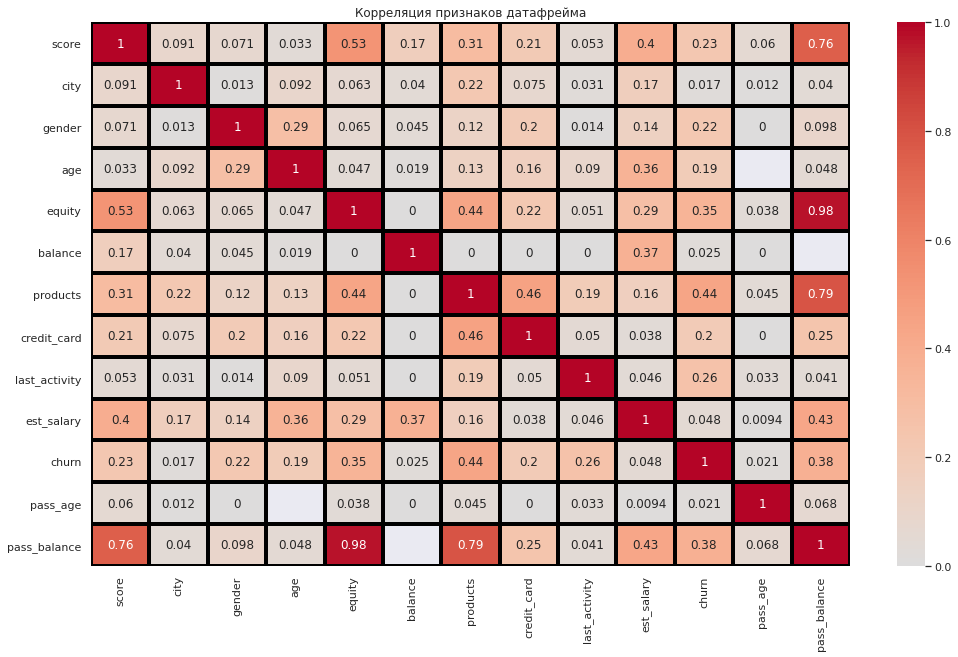

In [9]:
sns.set(rc={"figure.figsize": (17, 10)})
sns.heatmap(
    df.drop(columns='user_id').phik_matrix(interval_cols=['score', 'age', 'balance', 'est_salary']),
    #user_id добавлен в interval_cols, чтобы не высвечивалось окно предупреждения
    annot = True, fmt='.2g',
    linewidths=3,
    linecolor='black',
    cmap='coolwarm',
    center=0
)
plt.title('Корреляция признаков датафрейма')
plt.show()

Из матрицы видно, что пропуски в столбце `balance` сильно коррелируют с `equity`, так же есть достаточно сильная взаимосвязь с `score` и  `products`. Из этого следует, что данные пропуски появились не случайно, поэтому их заполнение может привести к искажениям.

В столбце `age` всего 26 пропусков, можно удалить.

In [10]:
#df['age'].fillna(df['age'].median(), inplace=True)
#df.drop(['pass_age'], axis=1, inplace=True)
df.dropna(subset=['age'], inplace=True)

### Приведение типов данных

In [11]:
df['age'] = df['age'].astype(int)
df['score'] = df['score'].astype(int)
df.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,pass_age,pass_balance
0,183012,850,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1,0,0
1,146556,861,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0,0,0
2,120722,892,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0,0,1
3,225363,866,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1,0,0
4,157978,730,Ярославль,М,34,5,174.00,1,1,0,67353.16,1,0,0


**В данном пункте была произведена предобработка данных:**
- Переименованы столбцы;
- Найдены неявные дубликаты, но принято решение их не удалять;
- Произведено кодирование категориальных данных;
- Заполнены пропуски в столбце `age`, пропуски в столбце `balance` принято решение не заполнять;
- Изменены типы данных в столбцах `score` и `age`.

## Исследовательский анализ данных

### Анализ распределения признаков в разрезе оттока

#### Проверить зависимость баллов кредитного скоринга и вероятности ухода

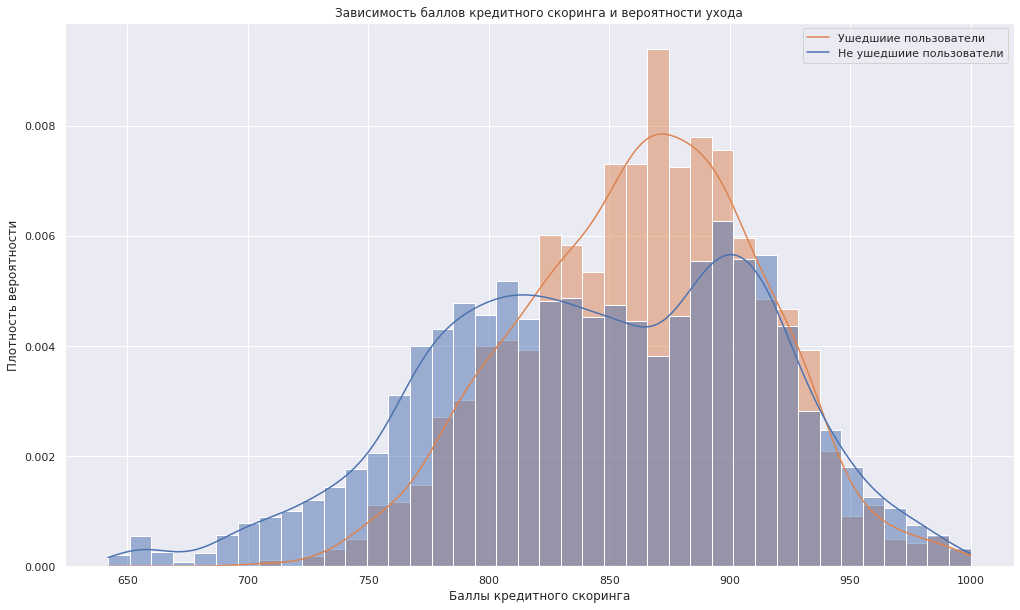

In [12]:
ax = sns.histplot(data=df, x='score', kde=True, stat="density", common_norm=False, hue='churn')
ax.set_title('Зависимость баллов кредитного скоринга и вероятности ухода')
ax.set_ylabel('Плотность вероятности')
ax.set_xlabel('Баллы кредитного скоринга')
plt.legend(labels=['Ушедшиие пользователи', 'Не ушедшиие пользователи'])
plt.show()

Видим, что чаще уходят пользователи с кредитным скорингом 825-910 баллов.

#### Зависимость пола и вероятности ухода

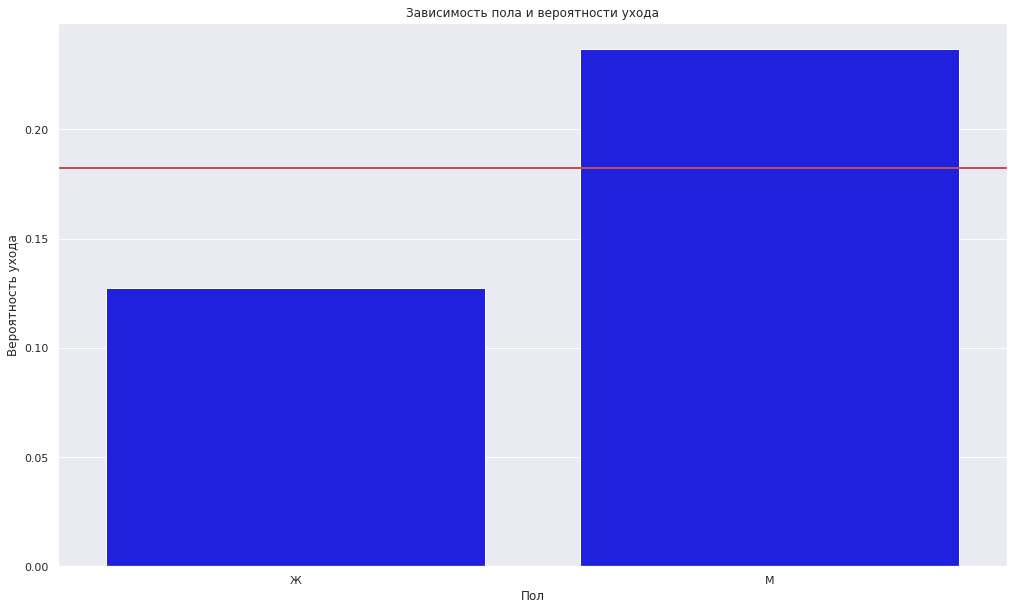

In [13]:
ax = sns.barplot(
    x='gender', 
    y='churn', 
    data=df, 
    color='blue',
    estimator=np.mean,
    ci=None
)
plt.axhline(
    np.mean(df['churn']),
    color='r',
    linestyle='-',
    linewidth=2,
    label='Mean'
)
ax.set_title('Зависимость пола и вероятности ухода')
ax.set_ylabel('Вероятность ухода')
ax.set_xlabel('Пол')
plt.show()

Мужчины более склонны уходить, чем женщины (вероятность `0,24` против `0,13`).

#### Зависимость города проживания и вероятности ухода

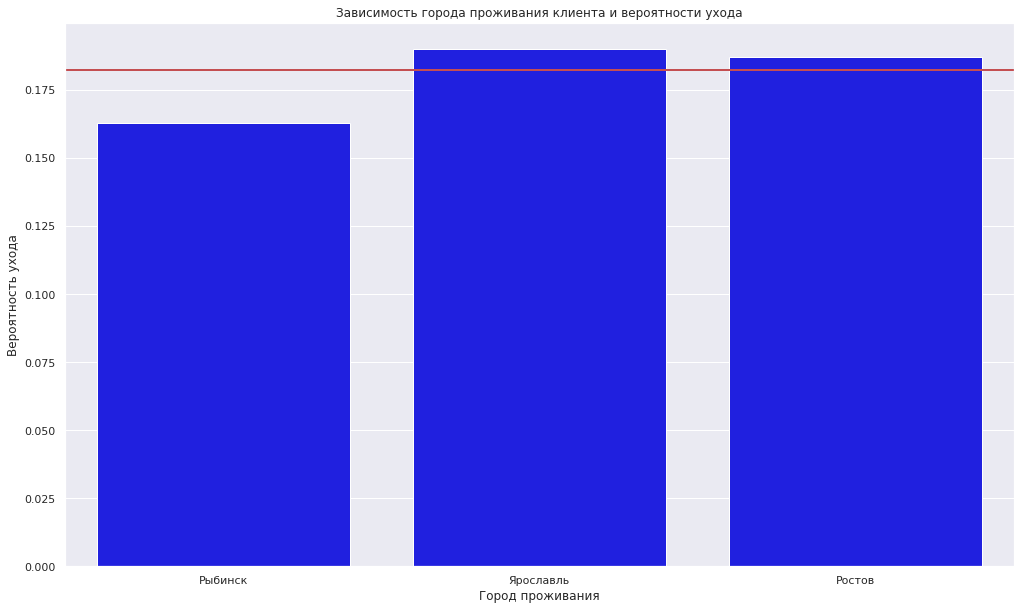

In [14]:
ax = sns.barplot(
    x='city', 
    y='churn', 
    data=df, 
    color='blue',
    estimator=np.mean,
    ci=None
)
plt.axhline(
    np.mean(df['churn']),
    color='r',
    linestyle='-',
    linewidth=2,
    label='Mean'
)
ax.set_title('Зависимость города проживания клиента и вероятности ухода')
ax.set_ylabel('Вероятность ухода')
ax.set_xlabel('Город проживания')
plt.show()

Клиенты из `Ярославля` и `Ростова` склонны к уходу несколько больше, чем из `Рыбинска`.

#### Зависимость возраста и вероятности ухода

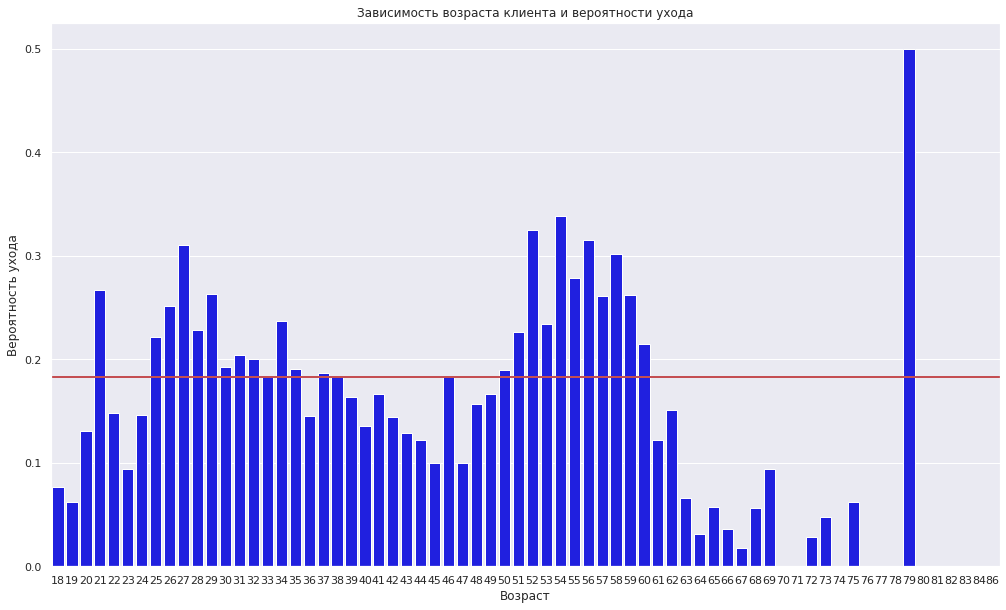

In [15]:
ax = sns.barplot(
    x='age', 
    y='churn', 
    data=df, 
    color='blue',
    estimator=np.mean,
    ci=None
)
plt.axhline(
    np.mean(df['churn']),
    color='r',
    linestyle='-',
    linewidth=2,
    label='Mean'
)
ax.set_title('Зависимость возраста клиента и вероятности ухода')
ax.set_ylabel('Вероятность ухода')
ax.set_xlabel('Возраст')
plt.show()

Видим, что наиболее склонны уходить клиенты в возрасте `21` года, `25-30` лет и `50-60` лет.

#### Зависимость баллов собственности и вероятности ухода

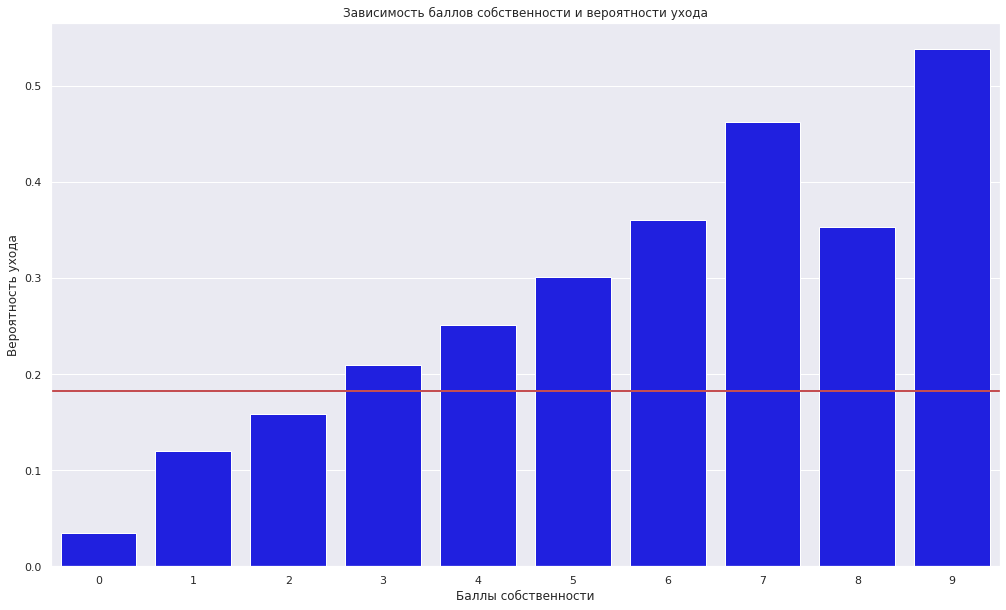

In [16]:
ax = sns.barplot(
    x='equity', 
    y='churn', 
    data=df, 
    color='blue',
    estimator=np.mean,
    ci=None
)
plt.axhline(
    np.mean(df['churn']),
    color='r',
    linestyle='-',
    linewidth=2,
    label='Mean'
)
ax.set_title('Зависимость баллов собственности и вероятности ухода')
ax.set_ylabel('Вероятность ухода')
ax.set_xlabel('Баллы собственности')
plt.show()

Видна явная зависимость увеличения вероятности оттока с увеличением баллов собственности. Возможно, отделу маркетинга стоит задуматься о внедрении программ страхования имущества для ужержания клиентов с высокими баллами собственности.

#### Зависимость баланса на счете и вероятности ухода

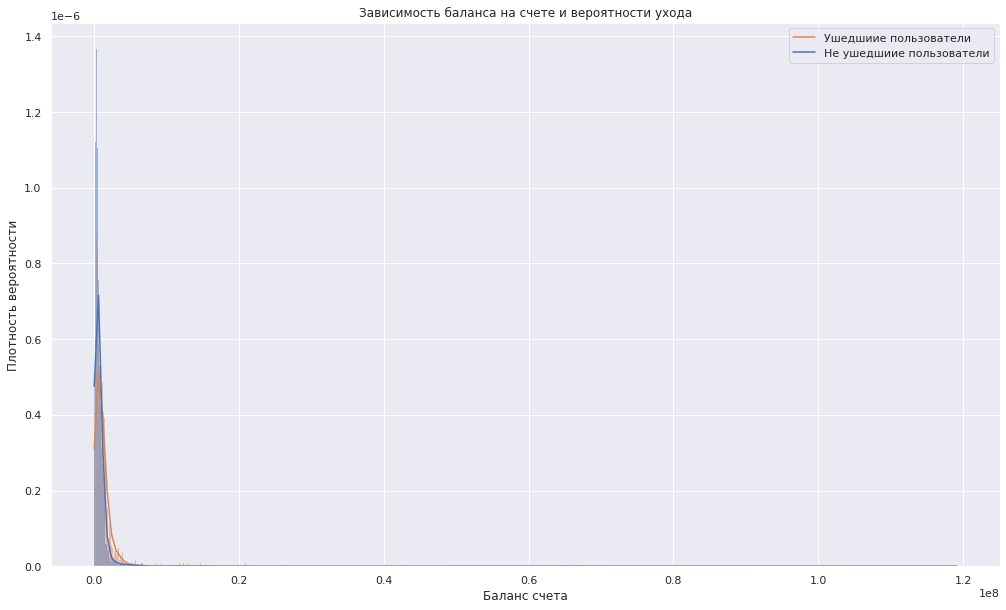

In [17]:
ax = sns.histplot(data=df, x='balance', kde=True, stat="density", common_norm=False, hue='churn')
ax.set_title('Зависимость баланса на счете и вероятности ухода')
ax.set_ylabel('Плотность вероятности')
ax.set_xlabel('Баланс счета')
plt.legend(labels=['Ушедшиие пользователи', 'Не ушедшиие пользователи'])
plt.show()

Из-за выбросов график не читаем. Построим боксплот для определения границы нормальных значений. Чтобы он быть информативен, ограничим отображение на диаграмме размаха отображение значений выше 20 000 000.

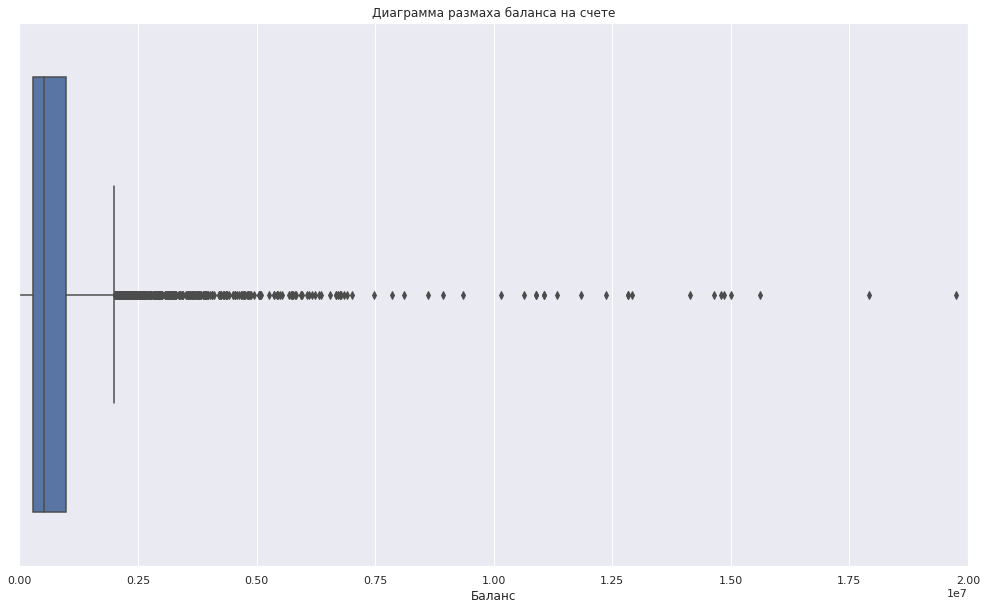

In [18]:
sns.boxplot(data=df, x="balance")
plt.xlim(0, 0.2*(10**8))
plt.title('Диаграмма размаха баланса на счете')
plt.xlabel("Баланс")
plt.show()

Оставим на графике зависимости баланса в разрезе оттока пользователей только суммы ниже 5 000 000.

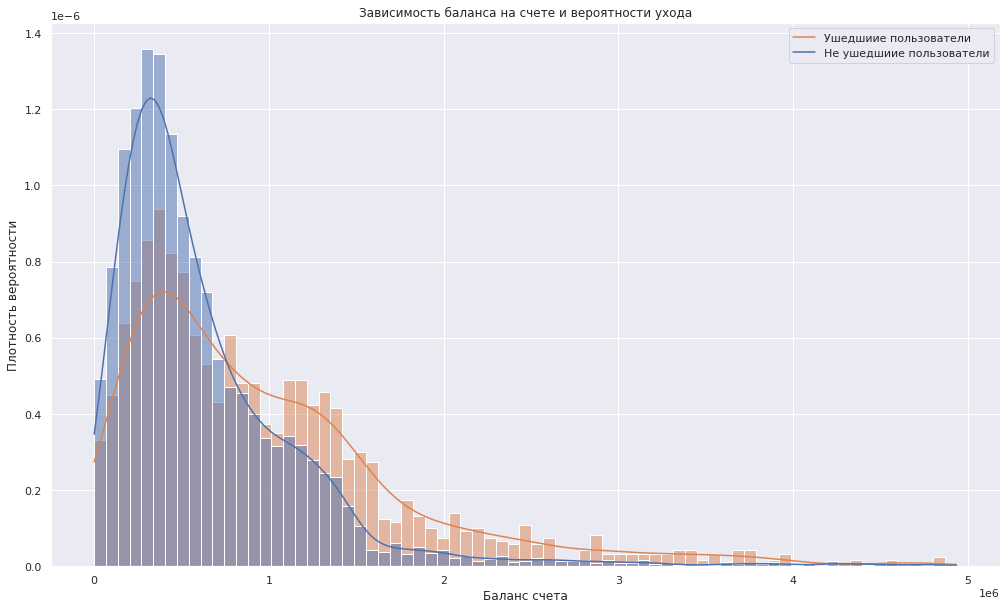

In [19]:
ax = sns.histplot(data=df.loc[df['balance'] <= 5000000], x='balance', kde=True, stat="density", common_norm=False, hue='churn')
ax.set_title('Зависимость баланса на счете и вероятности ухода')
ax.set_ylabel('Плотность вероятности')
ax.set_xlabel('Баланс счета')
plt.legend(labels=['Ушедшиие пользователи', 'Не ушедшиие пользователи'])
plt.show()

Видим, что более склонны уходить пользователи с балансом на сету от 1 млн.

#### Зависимость количества продуктов, которыми пользуется клиент и вероятности ухода

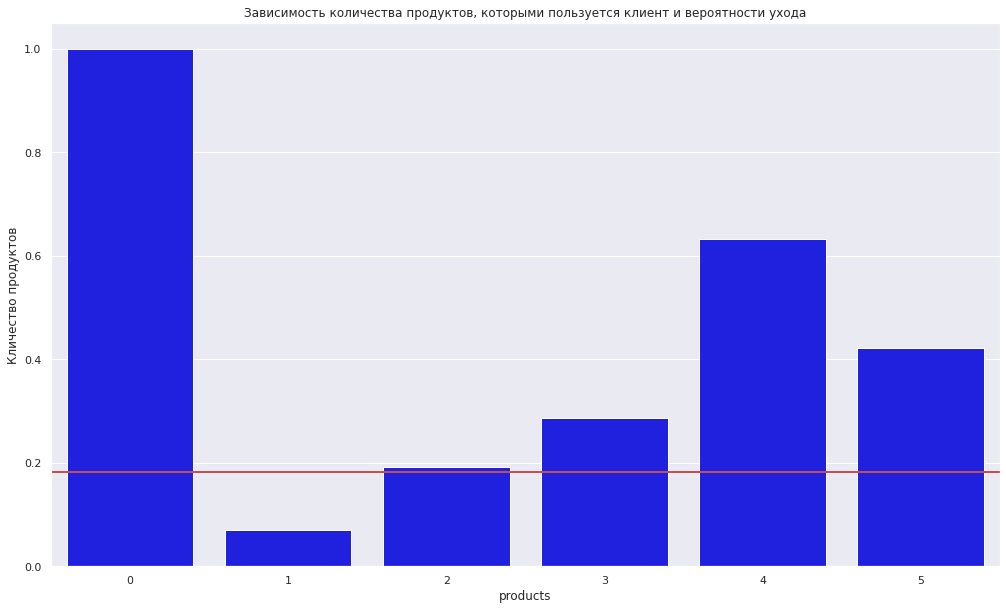

In [20]:
ax = sns.barplot(
    x='products', 
    y='churn', 
    data=df, 
    color='blue',
    estimator=np.mean,
    ci=None
)
plt.axhline(
    np.mean(df['churn']),
    color='r',
    linestyle='-',
    linewidth=2,
    label='Mean'
)
ax.set_title('Зависимость количества продуктов, которыми пользуется клиент и вероятности ухода')
ax.set_ylabel('Кличество продуктов')
plt.show()

Видим, что уходят пользователи либо не пользующиеся продуктами вовсе, либо пользующиеся `3-5` продуктами. Видимо, отделу маркетинга стоит обратить внимание на качество этих продуктов.
Так же видим отточность 100% у пользователей с нулем продуктов, посмотрим этих пользователей:

In [21]:
df.loc[df['products'] == 0]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,pass_age,pass_balance
8957,147837,962,Рыбинск,Ж,79,3,NaN,0,0,0,25063.96,1,0,1


Всего один человек. Видим пропуск в столбце `balance`. Данное значение аномально, удалим его.

In [22]:
df = df.loc[df['products'] != 0]

#### Проверить влияние наличия кредитной карты на вероятность ухода

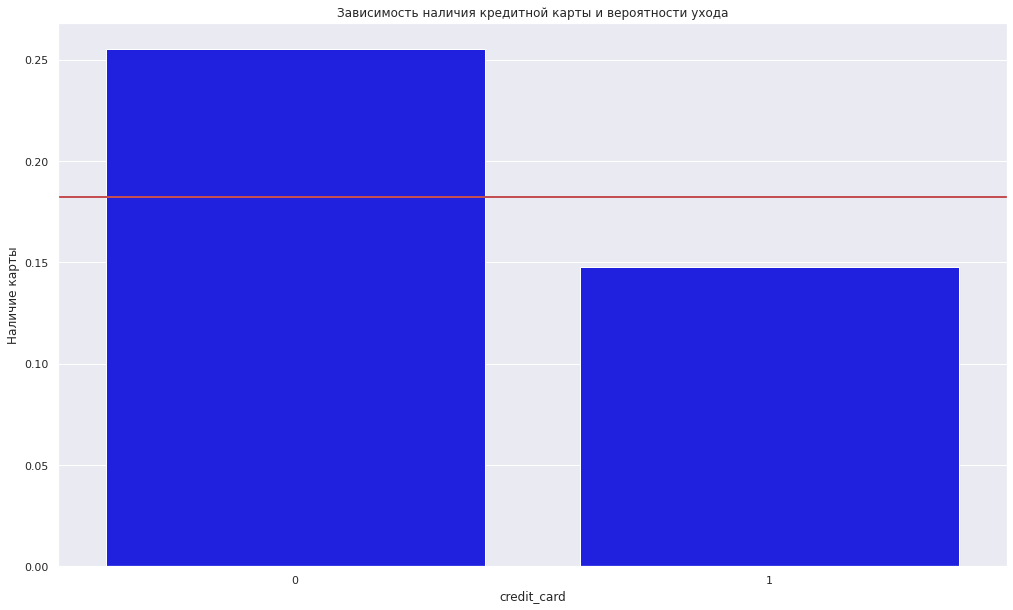

In [23]:
ax = sns.barplot(
    x='credit_card', 
    y='churn', 
    data=df, 
    color='blue',
    estimator=np.mean,
    ci=None
)
plt.axhline(
    np.mean(df['churn']),
    color='r',
    linestyle='-',
    linewidth=2,
    label='Mean'
)
ax.set_title('Зависимость наличия кредитной карты и вероятности ухода')
ax.set_ylabel('Наличие карты')
plt.show()

Отсутсвие кредитной карты сильно увеличивает вероятность ухода. По всей видимости, имеет смысл запустить регулярную компанию по продвижению кредитных продуктов.

#### Активности клиента определить вероятность ухода

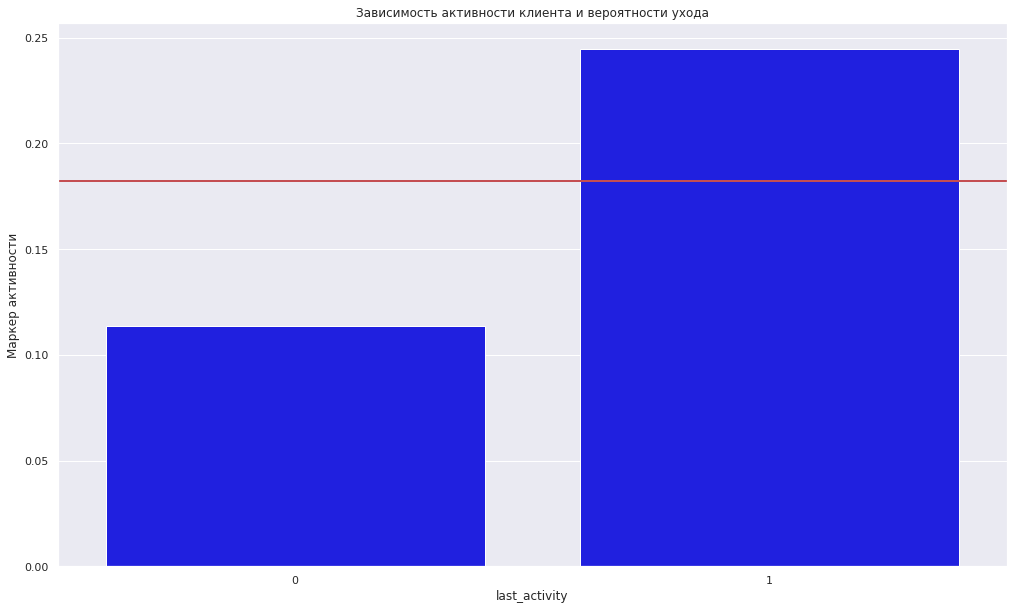

In [24]:
ax = sns.barplot(
    x='last_activity', 
    y='churn', 
    data=df, 
    color='blue',
    estimator=np.mean,
    ci=None
)
plt.axhline(
    np.mean(df['churn']),
    color='r',
    linestyle='-',
    linewidth=2,
    label='Mean'
)
ax.set_title('Зависимость активности клиента и вероятности ухода')
ax.set_ylabel('Маркер активности')
plt.show()

Видим, что вероятность ухода активного пользователя в 2 раза выше, чем неактивного.

#### Зависимость дохода клиента и вероятности ухода

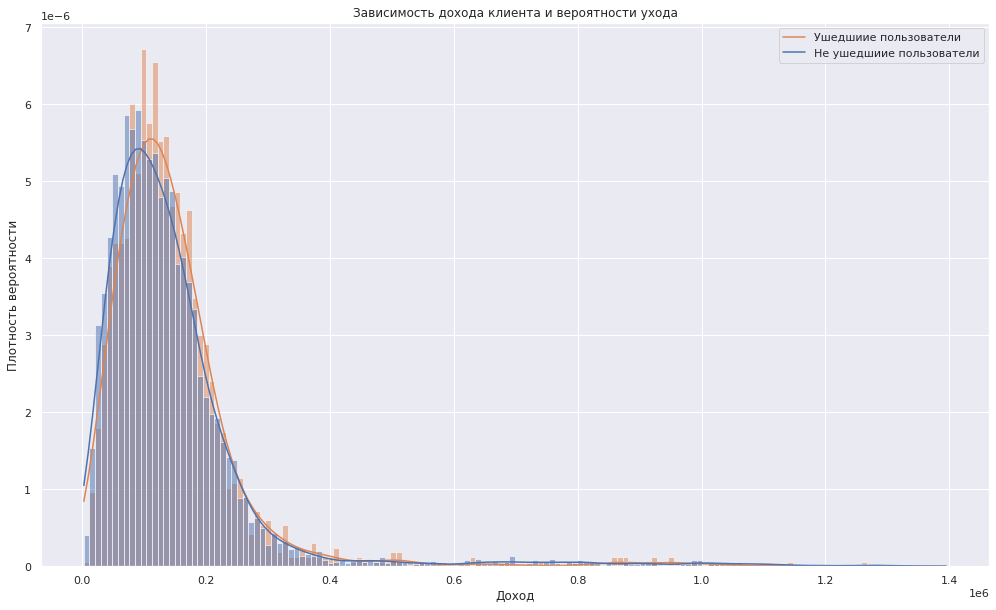

In [25]:
ax = sns.histplot(data=df, x='est_salary', kde=True, stat="density", common_norm=False, hue='churn')
ax.set_title('Зависимость дохода клиента и вероятности ухода')
ax.set_ylabel('Плотность вероятности')
ax.set_xlabel('Доход')
plt.legend(labels=['Ушедшиие пользователи', 'Не ушедшиие пользователи'])
plt.show()

Зависимости отточности от дохожа клиента не прослеживается.

**Добавить в таблицу категории отточности из предыдущих пунктов**

### Корреляционный анализ

Построим матрицу корреляций используя метод `phik`:

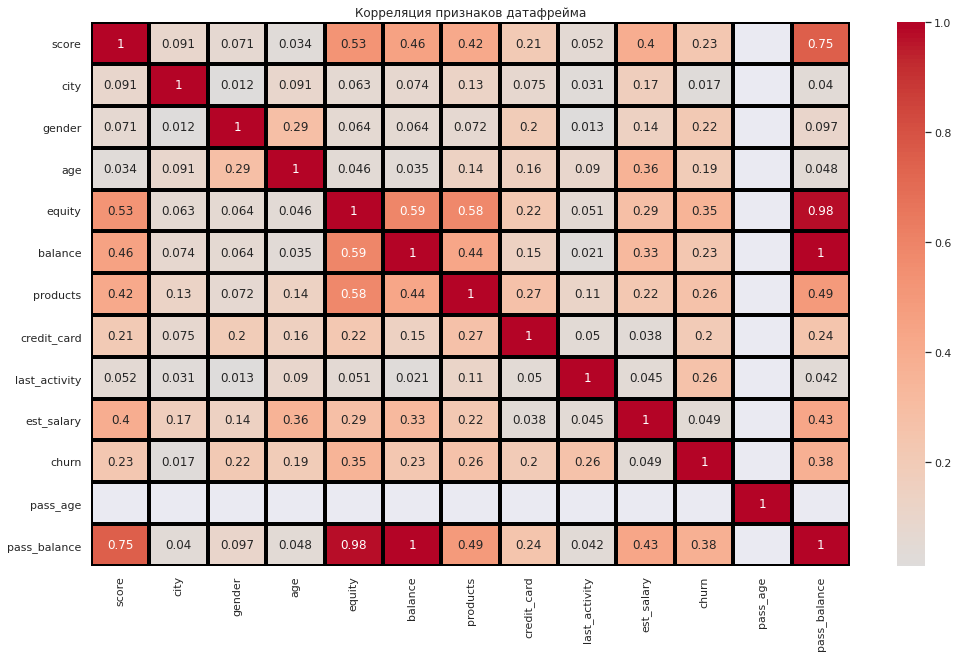

In [26]:
sns.set(rc={"figure.figsize": (17, 10)})
sns.heatmap(
    df.drop(columns='user_id').phik_matrix(interval_cols=['score', 'age', 'balance', 'est_salary'], dropna=False),
    #user_id добавлен в interval_cols, чтобы не высвечивалось окно предупреждения
    annot = True, fmt='.2g',
    linewidths=3,
    linecolor='black',
    cmap='coolwarm',
    center=0
)
plt.title('Корреляция признаков датафрейма')
plt.show()

Значительной корреляции оттока с каким-то одним параметром нет. Однако, стоит обратить внимание на корреляцию с баллами собственности и количеством продуктов.

**По итогам исследовательского анализа данных можно сделать следующие выводы:**
- Чаще уходят пользователи с кредитным скорингом `825`-`910` баллов;
- Мужчины более склонны уходить, чем женщины (вероятность `0,24` против `0,13`);
- Клиенты из `Ярославля` и `Ростова` склонны к уходу несколько больше, чем из `Рыбинска`;
- Склонны уходить клиенты в возрасте `21` года, `25-30` лет и `50-60` лет;
- Есть зависимость увеличения вероятности оттока с увеличением баллов собственности;
- Склонны уходить пользователи с балансом на сету от 1 млн;
- Уходят пользователи либо не пользующиеся продуктами вовсе, либо пользующиеся `3-5` продуктами;
- Отсутсвие кредитной карты сильно увеличивает вероятность ухода;
- Вероятность ухода активного пользователя в 2 раза выше, чем неактивного;
- Зависимости отточности от дохожа клиента не прослеживается;
- Значительной корреляции оттока с каким-то одним параметром нет. Однако, стоит обратить внимание на корреляцию с баллами собственности и количеством продуктов.

## Формулировка и проверка гипотез

### Гипотеза о различии дохода между клиентами, которые ушли и теми, которые остались

Сформулируем нулевую и альтернативную гипотезы:
- Н0 - Доход ушедших и оставшихся пользователей одинаков;
- Н1 - Доходы ушедших и оставшихся пользователей различны (двусторонняя).

Имеем две независимые выборки,**распределение которых близко к нормальному и от выбросов в которых мы можем избавиться (примем за границу нормальных значений доход в 600000),** поэтому проведем двухвыборочный t-тест для независимых выборок, перед этим отфильтровав выбросы:

In [27]:
print('Среднее выборки доходов оставшихся пользователей:', df.loc[(df['est_salary'] <= 600000) & (df['churn'] == 0)]['est_salary'].mean().round(2))
print('Среднее выборки доходов ушедших пользователей:', df.loc[(df['est_salary'] <= 600000) & (df['churn'] == 1)]['est_salary'].mean().round(2))
alpha = .05 #в задании не было задано, поэтому примем 0.05
results = st.ttest_ind(
    df.loc[(df['est_salary'] <= 600000) & (df['churn'] == 0)]['est_salary'],
    df.loc[(df['est_salary'] <= 600000) & (df['churn'] == 1)]['est_salary']
)
print('p-значение', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

Среднее выборки доходов оставшихся пользователей: 129497.26
Среднее выборки доходов ушедших пользователей: 136690.76
p-значение 0.0005531986279870109
Отвергаем нулевую гипотезу


Таким образом, мы отвергаем нулевую гипотезу о равентсве доходов ушедших и оставшихся пользователей в пользу гипотезы о том, что доходы не равны.

### Проверим гипотезу о том, что клиенты с балансом более 1 млн. более склонны к уходу, чем клиенты с балансом менее 1 млн.

Сформулируем нулевую и альтернативную гипотезы:
- Н0 - Баланс ушедших и оставшихся пользователей одинаков;
- Н1 - Баланс ушедших и оставшихся пользователей не одинаков (двусторонняя).

В данном случае не можем избавиться от выбросов **без потери важной информации и выборки распределены не нормально, следовательно, t-тест применить не получится**, поэтому применим тест Манна - Уитни:

In [28]:
print('Среднее выборки ,балансов оставшихся пользователей:', df.loc[df['churn'] == 0]['balance'].dropna().mean().round(2))
print('Среднее выборки балансов ушедших пользователей:', df.loc[df['churn'] == 1]['balance'].dropna().mean().round(2))
alpha = .05 #в задании не было задано, поэтому примем 0.05
results = st.mannwhitneyu(
    df.loc[(df['est_salary'] <= 600000) & (df['churn'] == 0)]['balance'].dropna(),
    df.loc[(df['est_salary'] <= 600000) & (df['churn'] == 1)]['balance'].dropna()
)
print('p-значение', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

Среднее выборки ,балансов оставшихся пользователей: 733031.63
Среднее выборки балансов ушедших пользователей: 1134458.21
p-значение 3.698924920784179e-69
Отвергаем нулевую гипотезу


Таким образом, мы отвергаем нулевую гипотезу о равентсве балансов ушедших и оставшихся пользователей в пользу гипотезы о том, что балансы не равны.

### Проверим гипотезу о разной склонности к уходу у мужчин и женщин

Сформулируем нулевую и альтернативную гипотезы:
- Н0 - Мужчины и женщины имеют одинаковую склонность к уходу;
- Н1 - Мужчины и женщины имеют неодинаковую склонность к уходу (двусторонняя).

Имеем соотношение пропорций, поэтому будем использовать z-тест.

Объявим функцию для проверки статистической значимости отличий в группах:

In [29]:
def z_test(s_0, s_1, t_0, t_1, alpha=0.05): #обозначим s_0 и s_1 - успехи в группах, t_0 и t_1 - количество пользователей в группах
    # пропорция успехов в первой группе:
    p1 = s_0/t_0
    # пропорция успехов во второй группе:
    p2 = s_1/t_1
    
    print(s_0,s_1 ,t_0 , t_1)
    # пропорция успехов в комбинированном датасете:
    p_combined = (s_0 + s_1) / (t_0 + t_1)
    #разница пропорций в датасетах
    difference = p1 - p2
    #считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/t_0 + 1/t_1))
    #задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница", '\n')
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными", '\n')

In [30]:
z_test(df.loc[(df['churn'] == 1) & (df['gender'] == 'М')]['user_id'].count(),
       df.loc[(df['churn'] == 1) & (df['gender'] == 'Ж')]['user_id'].count(),
       df.loc[df['gender'] == 'М']['user_id'].count(),
       df.loc[df['gender'] == 'Ж']['user_id'].count()
)

1183 635 4991 4982
p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница 



Таким образом, мы отвергаем нулевую гипотезу о том, что пользователи разных полов имеют одинаковую склонность к уходу в пользу гипотезы о том, что склонности не равны.

## Выводы по результатам исследования

**По результатам исследования можно сформировать следующие основные признаки отточности:**

- Мужской пол;
- Клиенты в возрасте `25`-`30` лет и `50`-`60` лет;
- Баланс на сете от `1` млн;
- Более `4` баллов собственности.

## Сегментация клиентов

### Клиенты мужского пола в возрасте 25-30 лет

Посчитаем размер и отток сегмента:

In [31]:
df_m_2530 = df.loc[(df['age'] >= 25) & (df['age'] <= 30) & (df['gender'] == 'М')]
print(f"Размер сегмента {df_m_2530.shape[0]}, отток сегмента {df_m_2530['churn'].mean().round(3)}, средний отток по банку {df['churn'].mean()}.")

Размер сегмента 717, отток сегмента 0.279, средний отток по банку 0.18229218891005716.


### Клиенты мужского пола в возрасте 50-60 лет

Посчитаем размер и отток сегмента:

In [32]:
df_m_5060 = df.loc[(df['age'] >= 50) & (df['age'] <= 60) & (df['gender'] == 'М')]
print(df_m_5060.shape[0], df_m_5060['churn'].mean())
print(f"Размер сегмента {df_m_5060.shape[0]}, отток сегмента {df_m_5060['churn'].mean().round(3)}, средний отток по банку {df['churn'].mean()}")

777 0.3333333333333333
Размер сегмента 777, отток сегмента 0.333, средний отток по банку 0.18229218891005716


### Клиенты с балансом на счете от 1 млн. и 4-мя более баллами собственности

Посчитаем размер и отток сегмента:

In [33]:
df_prime = df.loc[(df['balance'] >= 1000000) & (df['equity'] >= 4)]
print(df_prime.shape[0], df_prime['churn'].mean())
print(f"Размер сегмента {df_prime.shape[0]}, отток сегмента {df_prime['churn'].mean().round(3)}, средний отток по банку {df['churn'].mean()}")

1412 0.39660056657223797
Размер сегмента 1412, отток сегмента 0.397, средний отток по банку 0.18229218891005716


## Приоритезация сегментов

При приоретизации будем опираться на слежующие факторы:
- Размер сегмента;
- Отток сегмента;
- Трудозатраты по удержанию пользователей из данного сегмента.

По размеру и оттоку самым приоритетным можно сделать `третий` сегмент, однако, для удержания пользователей с большими счетами и высокими баллами собственности потребуются значительные затраты, поэтому данный сегмент будет иметь самый низкий приоритет из этих трех. Мужчины в возрасте `50`-`60` получат больший приоритет по сравнению с первым сегментом, так как размер данного сегмента и отток в нем выше. Таким образом приоритет будет выглядеть следующим образом:
1. Клиенты мужского пола в возрасте 50-60 лет
2. Клиенты мужского пола в возрасте 25-30 лет
3. Клиенты с балансом на счете от 1 млн. и 4-мя более баллами собственности

## Формулировка рекомендаций для бизнеса

**По итогам выделения и приоритезации сегментов можно дать следующие рекомендации бизнесу (номер пунтка ниже соответствует номеру сегмента из предыдущего пункта):**

1. Повышенный cashback на медицинские услуги, товары для охоты/рыбалки, акционные вклады/накопительные счета для данной категории клиентов;
2. Промокоды на стриминговые сервисы при открытии банковских продуктов (вклады, накопительные счета, кредитные карты и тд), cashback на кафе/рестораны, развлечения, образование.
3. Премиальным клиентам необходимо предложить возможность инвестировать свои средства: обучение инвестированию, НПФ, ЗПИФ, ОМС, страховые продукты (в т.ч. имущества) премиальная карта с повышенным cashback с категориями на выбор.